In [10]:
decimation = {729: 0.21796597814160018,
243: 0.24204682234160377,
81: 0.2399111765308416,
27: 0.27248521524034097,
9: 0.5165039142757681,
3: 0.8407635397872035}

In [11]:
average = {729: 0.4190887241636512,
243: 0.4258984130267677,
81: 0.4130546447023098,
27: 0.4388070374963901,
9: 0.5300782894508869,
3: 0.6991085496011913,
}

In [12]:
finegrained = {
2187: 0.745086302020691,
729: 0.7828621602210846,
243: 0.7895048877072426,
81: 0.7985982074599102,
27: 1.1203531956090642,
9: 1.943336344766188,
}

In [13]:
coarsegrained = {
729: 0.4348029443359942,
243: 0.4261722612203924,
81: 0.4007550553791729,
27: 0.5055353817943444,
9: 0.6354479748002932,
    3: 0.8743735866750878
}

In [14]:
# average_no_discretization = {729: 0.5809884357106417,
# 243: 0.602560199802972,
# 81: 0.6077185871005902,
# 27: 0.6210821870971144,
# 9: 0.7015421812624651,
# 3: 0.841320987242109}

In [18]:
average_no_discretization_nocenter = {729: 0.5947182136225934,
243: 0.6186316080413407,
81: 0.6224645356863239,
27: 0.6333916045785863,
9: 0.718387392616263,
3: 0.858402816011503}


In [21]:
coarsegrained_nodiscretization = {
729: 0.6020829782359466,
243: 0.6366705000361497,
81: 0.5847558900309876,
27: 0.6648668227657395,
9: 0.7568898352116225,
3: 0.9239635696980291,
}

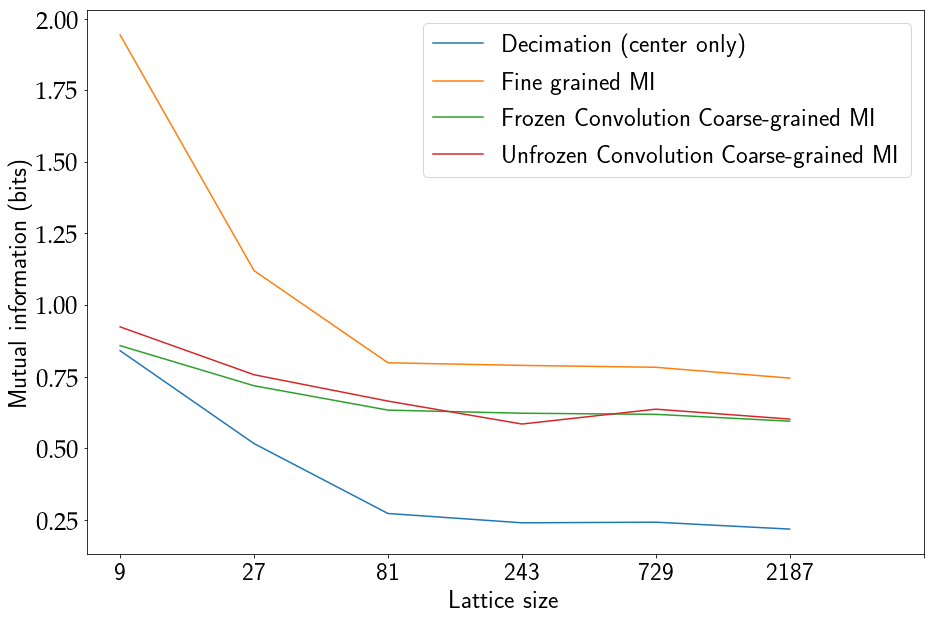

In [36]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Palatino'], "size":25})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.figure(figsize=(15,10))
for diction in [decimation, average, coarsegrained, finegrained, average_no_discretization_nocenter, coarsegrained_nodiscretization]:
    k, v = zip(*diction.items())
    if diction == finegrained:
        plt.plot(range(6), v[::-1], label = "Fine grained MI")
    elif diction == decimation:
        plt.plot(range(6), v[::-1], label = "Decimation (center only)")
#     elif diction == average:
#         plt.plot(range(6), v[::-1], label = "Average (with discretization)")
# #     elif diction == coarsegrained:
# #         plt.plot(range(6), v[::-1], label = "Trained coarse graining")
    elif diction == coarsegrained_nodiscretization:
        plt.plot(range(6), v[::-1], label = "Unfrozen Convolution Coarse-grained MI")
    elif diction == average_no_discretization_nocenter:
        plt.plot(range(6), v[::-1], label = "Frozen Convolution Coarse-grained MI")
        
plt.xticks(ticks= range(7), labels=[9, 27, 81, 243, 729, 2187])
plt.xlabel("Lattice size")
plt.ylabel("Mutual information (bits)")
plt.legend()
plt.show()

In [50]:
len([1341829, 71084, 241686, 504322, 504103, 1346502, 222693, 507400, 44840, 118413, 25828, 22201, 239841, 505322, 45493, 240842, 50628, 24542, 68743, 38519, 24228, 124456, 38806, 38841, 222440, 24177, 241178, 117442, 23340, 26124, 33279, 46314, 118750, 27231, 24685, 24720, 49756, 23245, 124774, 46169, 26160, 23982, 33440, 24450, 76181, 45804, 16337, 29093, 118666, 68652, 76258, 33996, 125240, 18438, 27460, 26042, 45066, 21340, 75962, 68814, 50335, 16260, 26333, 124653, 28811, 26360, 23204, 27293, 33523, 33936, 26576, 70999, 68744, 24618, 24711, 45303, 33266, 50194, 11407, 33937, 18577, 22237, 33470, 24027, 23246, 76017, 23935, 27482, 38782, 33645, 28875, 16208, 16205, 26213, 33041, 46326, 24799, 29073, 21078, 11134])

100

In [ ]:
[1, 1] 

In [28]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import math
import numpy as np
import sys

# Load parameters
class SupervisedConvNet(nn.Module):
    def __init__(self, filter_size, square_size, hidden_size, num_hidden_layers, center,
                first_activation = "tanh", activation_func = "sigmoid",
                out_channels = 1):
        """
        Arguments:
        filter_size ~ size of the convolution kernel (3 x 3)
        square size ~ how many strides of convolution in the input
        """
        super(SupervisedConvNet, self).__init__()
        self.filter_size = filter_size
        self.square_size = square_size
        self.hidden_size = hidden_size
        self.out_channels = out_channels
        if first_activation == "tanh":
            self.first_activation = torch.tanh
        elif first_activation == "relu":
            self.first_activation = torch.nn.LeakyReLU(0.1)
        if activation_func == "sigmoid":
            self.activation_func = torch.sigmoid
        elif activation_func == "relu":
            self.activation_func = torch.nn.LeakyReLU(0.1)

        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        # parameters
        param = {}
        if center == "keep":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/9
            # param['conv2d.bias'] = torch.tensor([0.0])
        elif center == "omit":
            param['conv2d.weight'] = torch.tensor([[[[1.0, 1.0, 1.0],
                      [1.0, 0.0, 1.0],
                      [1.0, 1.0, 1.0]]]])/8
            # param['conv2d.bias'] = torch.tensor([0.0])
        elif center == "pre_trained":
            param['conv2d.weight'] = torch.tensor([[[[ 0.5417, -0.0390,  0.5055],
          [-0.0826, -0.0543, -0.1356],
          [ 0.4852, -0.0602,  0.5061]]]])
            param['conv2d.bias'] = torch.tensor([-0.0523])

            self.conv1.bias = torch.nn.Parameter(param['conv2d.bias'], requires_grad=False)
        self.conv1.weight = torch.nn.Parameter(param['conv2d.weight'], requires_grad=False)


#         self.first_linear = nn.Linear(self.out_channels * square_size ** 2, hidden_size)
#         hidden_layer = [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
#         self.linear_hidden = nn.ModuleList(hidden_layer)
#         self.linear_output = nn.Linear(hidden_size, 1)



    def forward(self, x):
        x = self.first_activation(self.conv1(x))#.view(-1, 1, self.out_channels * self.square_size**2)
#         x = self.activation_func(self.first_linear(x))
#         for linear in self.linear_hidden:
#             x = self.activation_func(linear(x))
#         x = torch.sigmoid(self.linear_output(x))
#         x = x.squeeze(1)

        return x



In [29]:
model = SupervisedConvNet(filter_size = 3, square_size = 3, \
                    hidden_size = 10, out_channels = 1,
                    center = "pre_trained", first_activation = "tanh",
                    activation_func = "relu", num_hidden_layers = 1)
data = []
data = np.load("/Users/qanguyen/Downloads/ising_temp2.269_correlated9x9from27x27.npy")#[-5700:]
data.shape

(9999, 9, 9)

In [40]:
data[0, :3, :3]

array([[0.68040556, 0.25448543, 0.71785986],
       [0.64211714, 0.4861948 , 0.63988304],
       [0.6465981 , 0.68612653, 0.7362984 ]], dtype=float32)

In [42]:
np.save("/Users/qanguyen/Downloads/ising_temp2.269_correlated3x3from9x9.npy", model(torch.tensor(data[:, None, :, :])).squeeze(1).numpy())

In [8]:
import numpy as np
v = np.array([-3,4,2], dtype=int)

In [9]:
np.frombuffer(v.tostring(), dtype=int)

array([-3,  4,  2])